In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Read the country reference file
df_countries = pd.read_csv("CT_COUNTRIES.csv", sep=";", header=None, names=["code", "lang", "name"])

country_dict = df_countries.set_index("code")["name"].to_dict()

In [3]:
import io

FILE_PATH     = "EXPORT_DATA_envoi_01_01_2022_30_04_2025.csv"
TARGET_BYTES  = 1 * 1024**3          # ≈1 GB
ENCODING      = "utf-8-sig"          # handles UTF-8 + BOM

def load_gb_chunk(path, chunk_index=0, target_bytes=TARGET_BYTES, **read_kwargs):
    """
    Load the N-th ≈1 GB chunk (0-based) from a large CSV.

    Parameters
    ----------
    path : str
        CSV file path.
    chunk_index : int
        0 for the first gigabyte, 1 for the second, and so on.
    target_bytes : int
        Approximate raw size for each chunk (defaults to 1 GB).

    Returns
    -------
    pandas.DataFrame
        The requested slice as a DataFrame.
    """
    with open(path, "rb") as f:
        header = f.readline()            # capture header once

        # -------- skip over the earlier chunks --------
        for _ in range(chunk_index):
            skipped = 0
            while skipped < target_bytes:
                line = f.readline()
                if not line:             # hit EOF too soon
                    raise ValueError("chunk_index beyond end of file")
                skipped += len(line)

        # -------- collect the requested chunk --------
        buffers      = [header]
        bytes_so_far = len(header)

        while bytes_so_far < target_bytes:
            line = f.readline()
            if not line:                 # EOF
                break
            bytes_so_far += len(line)
            buffers.append(line)

    pseudo_file = io.BytesIO(b"".join(buffers))

    df = pd.read_csv(
        pseudo_file,
        sep=";",
        encoding=ENCODING,
        on_bad_lines="skip",
        dtype=str,
        low_memory=False,
        **read_kwargs,
    )

    # strip any stray BOM from the first column name
    df.columns = df.columns.str.lstrip("\ufeff")
    return df

# -------- examples --------
df = load_gb_chunk(FILE_PATH, chunk_index=1)  # second GB

print("Second:", df.shape)


Second: (8936983, 7)


In [4]:
first_row_df = df.head(1)   # first_row_df.shape == (1, df.shape[1])
first_row_df

,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal
0,SGSINBDZALGDAUR32033002010102,RB309894919SG,Expédition d'envoi à l'étranger (EDI-reçu),2023-10-08 12:15:00.000,SINGAPOUR,12,ALGÉRIE


In [5]:
last_row_df  = df.tail(1)   # last_row_df.shape  == (1, df.shape[1])
last_row_df

,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal
8936982,AEDXBADZALGBAUR40052006000151,RR016746475AE,Vaine tentative de livraison d'envoi (Ent),2024-09-19 08:55:37.300,BORDJ MENAEIL,36,NaN


In [6]:
distinct_values_count = df.nunique()

distinct_values_count = distinct_values_count.sort_values(ascending=True)

print(distinct_values_count)

EVENT_TYPE_NM                     21
EVENT_TYPE_CD                     21
next_établissement_postal       3502
établissement_postal            3645
RECPTCL_FID                    50848
MAILITM_FID                  1918261
date                         7965129
dtype: int64


In [9]:
print("the number of not missing bags is", 8936983 - 6025415)

the number of not missing bags is 2911568


In [10]:
missing_values = df.isnull().sum()
missing_columns = missing_values[missing_values > 0]
print(missing_columns)

RECPTCL_FID                  6025415
établissement_postal           25019
next_établissement_postal    5093987
dtype: int64


In [11]:

# Assuming 'df' is your DataFrame!

# Identify the rows with missing values
missing_rows = df[df.isnull().any(axis=1)]

# Print the total number of rows that have missing values
print("Total rows with missing values:", missing_rows.shape[0])




Total rows with missing values: 7463393


In [12]:
# Analyze the missing patterns across rows:
# Create a binary pattern for each row where 1 indicates a missing value and 0 indicates non-missing.
missing_pattern = missing_rows.isnull().astype(int)
# Convert each pattern to a tuple to use as a key for groupby
missing_pattern_tuples = missing_pattern.apply(tuple, axis=1)
# Group by the missing pattern and count the number of rows for each pattern
pattern_summary = missing_rows.groupby(missing_pattern_tuples).size().sort_values(ascending=False)

print("\nSummary of missing patterns (tuple of 0's and 1's corresponding to missing values in each column):")
print(pattern_summary)




Summary of missing patterns (tuple of 0's and 1's corresponding to missing values in each column):
(1, 0, 0, 0, 0, 0, 1)    3681028
(1, 0, 0, 0, 0, 0, 0)    2344387
(0, 0, 0, 0, 0, 0, 1)    1412959
(0, 0, 0, 0, 1, 0, 0)      25019
dtype: int64


In [13]:
unique_vals = df['next_établissement_postal'].dropna().unique()
for v in unique_vals:
    print(repr(v))

'ALGÉRIE'
'ALGER GARE'
'HASSI BAHBAH'
'HASSI-BAHBAH-DJAAROUNE-SAID'
'CDD OUM EL BOUAGHI'
'CDD SETIF'
'CDD EL EULMA'
'HARICHA'
'CTR CHLEF'
'CONSTANTINE COLIS POSTAUX'
'EL MINZAH'
'BIR MOURAD RAIS'
'CDD BOUMERDES FRANTZ FANON'
'ANNABA EL MARSA'
'CDD SKIKDA'
'SIDI-MEZGHICHE'
'CTR GHARDAIA'
'BENI ISGUEN'
'CDD MEDEA'
'OUED-RIGHA'
'OUED-KSOB'
'CDD TEBESSA'
'BOUKHADRA'
'SECTION PAQUETS CPX ALGER'
'CDD HASSI MESSAOUD'
'BABA HASSEN'
'ORAN COLIS POSTAUX'
'BIRKHADEM'
'CDD KHENCHELA'
'EL BOUNI'
'OUED SMAR'
'CDD TLEMCEN'
'EL-KANTARA 1ER NOV,'
'CDD MILA'
'OUED-ATHMENIA'
'MILA-SENNAOUA'
'BOUZAREAH'
'CDD BENAKNOUN'
'ALGER COLIS POSTAUX'
'DAR EL BEIDA'
'CDD BLIDA'
'AL AFROUNE'
'OUREAH'
'CDD KOUBA'
'CDD TIZI-OUZOU'
'CDD LAGHOUAT'
'AIN-MADHI'
'CDD MOSTAGHANEM'
'BENI-BECHIR'
'EL EULMA RP'
'CDD GHARDAIA'
'HASSASNA'
'CTR BISKRA'
'CDD CONSTANTINE'
'MOHAMMADIA'
'CHLEF-BENSOUNA'
'CDD JIJEL'
'JIJEL-SOUMMAM'
'CTR MEDEA'
'BOURROUAGHIA 1ER NOV'
'CHETAIBI'
'CDD TIARET'
'TIARET-ZAAROURA'
'CDD BOUIRA'
'CDD BBA'
'MOHA

EVENT_TYPE_NM
Recevoir envoi au bureau de livraison (Ent)                    1869666
Expédier envoi à adresse nationale (Ent)                       1679139
Expédier envoi à adresse nationale (Srt)                       1319064
Recevoir envoi au bureau d'échange (Ent)                       1019417
Expédition d'envoi à l'étranger (EDI-reçu)                      823939
Livraison d'envoi (Ent)                                         822203
Vaine tentative de livraison d'envoi (Ent)                      728658
Transmettre envoi à l'agent de livraison (Ent)                  531650
Enregistrer détails d'envoi au bureau d'échange (Srt)            83740
Insérer envoi dans sac (Srt)                                     23411
Recevoir envoi au bureau d'échange (Srt)                         15847
Expédier envoi à la douane (Ent)                                 13673
Renvoyer envoi de la douane (Ent)                                 5435
Renvoyer envoi de la douane (Srt)                              

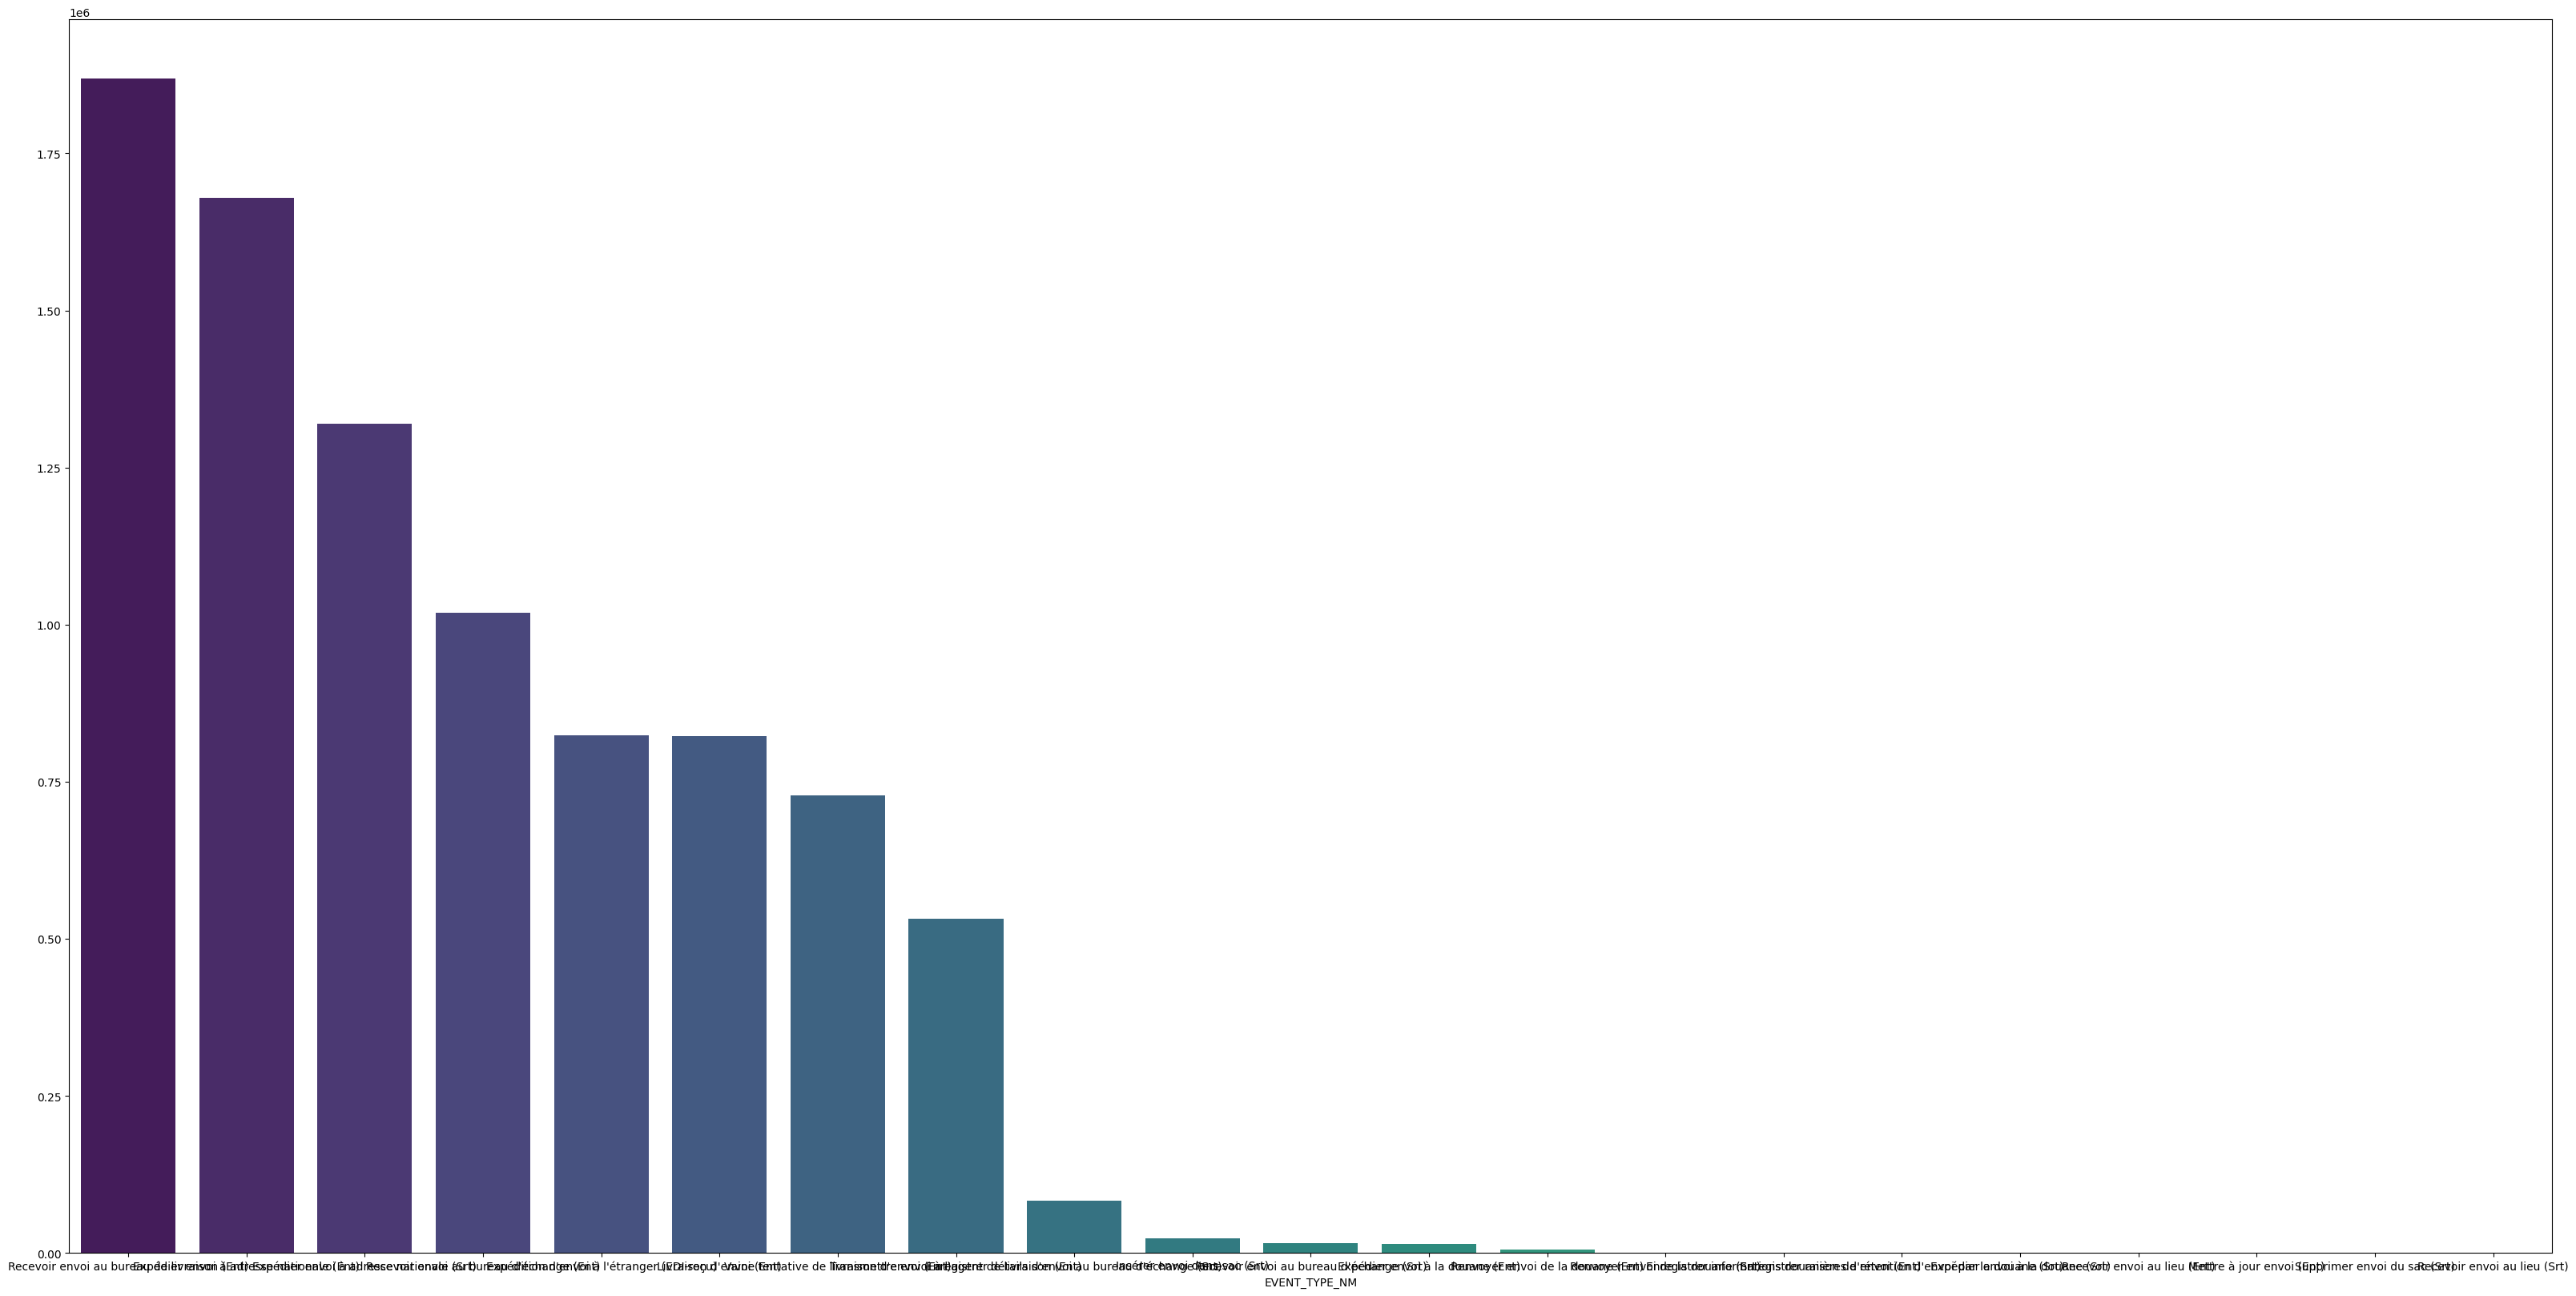

In [14]:

# Count the occurrences of each protocol
event_type = df['EVENT_TYPE_NM'].value_counts()

print(event_type)

# Visualize the counts of each protocol
plt.figure(figsize=(40, 20))
sns.barplot(x=event_type.index, y=event_type.values, palette='viridis')
plt.show()

In [15]:

# Count the occurrences of each protocol
proto_counts = df['établissement_postal'].value_counts()

print(proto_counts)


établissement_postal
ALGER COLIS POSTAUX          1591350
ALGER GARE                   1031782
SINGAPOUR                     777627
ANNABA EL MARSA               307558
CONSTANTINE COLIS POSTAUX     244330
                              ...   
MAARAF ABDELLAH                    1
EL-IDRISSIA-11 DEC 1960            1
DRAA-SOUARY                        1
BURKINA FASO                       1
AIT OULHADJ                        1
Name: count, Length: 3645, dtype: int64


In [16]:
# Count the occurrences of each protocol
proto_counts = df['next_établissement_postal'].value_counts()

print(proto_counts)



next_établissement_postal
ALGÉRIE                      823939
SECTION PAQUETS CPX ALGER    369241
ALGER GARE                   330655
CONSTANTINE COLIS POSTAUX    172877
ORAN COLIS POSTAUX           151360
                              ...  
MOSTAGANEM-GARE-ROUTIERE          1
ZEMOURA                           1
MASCARA MAACHE ALI                1
TAMTERT                           1
TAMANRASSET-ASSIHAR               1
Name: count, Length: 3502, dtype: int64


In [17]:
# Rows whose RECPTCL_FID is not NaN
rec_present = df[df["RECPTCL_FID"].notna()]

# Show the first five
rec_present.head()


,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal
0,SGSINBDZALGDAUR32033002010102,RB309894919SG,Expédition d'envoi à l'étranger (EDI-reçu),2023-10-08 12:15:00.000,SINGAPOUR,12,ALGÉRIE
1,SGSINBDZALGDAUR32033002010102,RB309922835SG,Expédition d'envoi à l'étranger (EDI-reçu),2023-10-08 12:15:00.000,SINGAPOUR,12,ALGÉRIE
2,SGSINBDZALGDAUR32033002010102,RB309960290SG,Expédition d'envoi à l'étranger (EDI-reçu),2023-10-08 12:15:00.000,SINGAPOUR,12,ALGÉRIE
3,SGSINBDZALGDAUR32033002010102,RB309961468SG,Expédition d'envoi à l'étranger (EDI-reçu),2023-10-08 12:15:00.000,SINGAPOUR,12,ALGÉRIE
4,SGSINBDZALGDAUR32033002010102,RB309969308SG,Expédition d'envoi à l'étranger (EDI-reçu),2023-10-08 12:15:00.000,SINGAPOUR,12,ALGÉRIE


In [18]:
# 1️⃣  Make sure the column is treated as text (protects against NaNs)
fid = df["MAILITM_FID"].astype("string")

# 2️⃣  Boolean mask: True if both trailing characters are letters (A-Z / a-z)
two_letter_suffix = fid.str[-2:].str.isalpha()

# --- Quick sanity check
print(two_letter_suffix.value_counts(dropna=False))
# True  : rows where the code ends in letters (e.g. "ES")
# False : rows where it ends in digits or something else
# <NA>  : rows where MAILITM_FID itself is missing


MAILITM_FID
True    8936983
Name: count, dtype: Int64


In [19]:
bad_suffix = df[~two_letter_suffix & fid.notna()]

print(f"Bad rows: {len(bad_suffix):,}")
bad_suffix.head()   # peek at the first few offenders



Bad rows: 0


,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal


In [20]:
# Build the “good suffix” mask once
suffix_ok = (
    df["MAILITM_FID"]
      .astype("string")
      .str[-2:]
      .str.isalpha()
      .fillna(False)          # treat missing IDs as bad
)

df = df[suffix_ok]

# Quick confirmation
print(f"Rows left: {len(df):,}")
df.head()


Rows left: 8,936,983


,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal
0,SGSINBDZALGDAUR32033002010102,RB309894919SG,Expédition d'envoi à l'étranger (EDI-reçu),2023-10-08 12:15:00.000,SINGAPOUR,12,ALGÉRIE
1,SGSINBDZALGDAUR32033002010102,RB309922835SG,Expédition d'envoi à l'étranger (EDI-reçu),2023-10-08 12:15:00.000,SINGAPOUR,12,ALGÉRIE
2,SGSINBDZALGDAUR32033002010102,RB309960290SG,Expédition d'envoi à l'étranger (EDI-reçu),2023-10-08 12:15:00.000,SINGAPOUR,12,ALGÉRIE
3,SGSINBDZALGDAUR32033002010102,RB309961468SG,Expédition d'envoi à l'étranger (EDI-reçu),2023-10-08 12:15:00.000,SINGAPOUR,12,ALGÉRIE
4,SGSINBDZALGDAUR32033002010102,RB309969308SG,Expédition d'envoi à l'étranger (EDI-reçu),2023-10-08 12:15:00.000,SINGAPOUR,12,ALGÉRIE


In [5]:
df['id'] = df["MAILITM_FID"].str[-2:]
df.head()

,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal,id
0,SGSINBDZALGDAUR32033002010102,RB309894919SG,Expédition d'envoi à l'étranger (EDI-reçu),2023-10-08 12:15:00.000,SINGAPOUR,12,ALGÉRIE,SG
1,SGSINBDZALGDAUR32033002010102,RB309922835SG,Expédition d'envoi à l'étranger (EDI-reçu),2023-10-08 12:15:00.000,SINGAPOUR,12,ALGÉRIE,SG
2,SGSINBDZALGDAUR32033002010102,RB309960290SG,Expédition d'envoi à l'étranger (EDI-reçu),2023-10-08 12:15:00.000,SINGAPOUR,12,ALGÉRIE,SG
3,SGSINBDZALGDAUR32033002010102,RB309961468SG,Expédition d'envoi à l'étranger (EDI-reçu),2023-10-08 12:15:00.000,SINGAPOUR,12,ALGÉRIE,SG
4,SGSINBDZALGDAUR32033002010102,RB309969308SG,Expédition d'envoi à l'étranger (EDI-reçu),2023-10-08 12:15:00.000,SINGAPOUR,12,ALGÉRIE,SG


In [23]:

# Count the occurrences of each protocol
proto_counts = df['id'].value_counts()

print(proto_counts)

s = proto_counts


id
SG    4394522
CZ    2125559
AE    2105788
MY     170401
NL      46279
       ...   
SB          1
TJ          1
ME          1
AM          1
IL          1
Name: count, Length: 107, dtype: int64


In [24]:
# Map the Series index using the country_dict
s.index = s.index.map(lambda code: country_dict.get(code, code))  # Keep unmapped codes as-is
print(s)

id
SINGAPOUR              4394522
TCHÈQUE, RÉPUBLIQUE    2125559
ÉMIRATS ARABES UNIS    2105788
MALAISIE                170401
PAYS-BAS                 46279
                        ...   
SALOMON, ÎLES                1
TADJIKISTAN                  1
ME                           1
ARMÉNIE                      1
ISRAËL                       1
Name: count, Length: 107, dtype: int64


In [25]:
print("Min date:", df["date"].min())
print("Max date:", df["date"].max())

Min date: 2005-11-08 23:41:47.500
Max date: 2025-05-21 16:13:21.467


In [6]:
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d %H:%M:%S.%f")
# Sort by ID and date
df = df.sort_values(by=["MAILITM_FID", "date"])

# Calculate time to next step
df["duration_to_next_step"] = df.groupby("MAILITM_FID")["date"].shift(-1) - df["date"]

# Calculate total duration per ID
first_date = df.groupby("MAILITM_FID")["date"].transform("first")
last_date = df.groupby("MAILITM_FID")["date"].transform("last")
df["total_duration"] = last_date - first_date

# Preview the updated dataset
df[["MAILITM_FID", "date", "EVENT_TYPE_NM", "duration_to_next_step", "total_duration"]].head(10)


,MAILITM_FID,date,EVENT_TYPE_NM,duration_to_next_step,total_duration
909514,CA000020800LY,2022-02-12 14:15:00,Expédition d'envoi à l'étranger (EDI-reçu),NaT,0 days 00:00:00
934398,CA000086085US,2024-11-24 21:30:00,Expédition d'envoi à l'étranger (EDI-reçu),NaT,0 days 00:00:00
940815,CA000094303US,2024-11-22 05:15:00,Expédition d'envoi à l'étranger (EDI-reçu),2 days 16:15:00,2 days 16:15:00
934399,CA000094303US,2024-11-24 21:30:00,Expédition d'envoi à l'étranger (EDI-reçu),NaT,2 days 16:15:00
926996,CA000102985US,2024-11-25 05:00:00,Expédition d'envoi à l'étranger (EDI-reçu),NaT,0 days 00:00:00
940835,CA000132868US,2024-11-30 05:15:00,Expédition d'envoi à l'étranger (EDI-reçu),NaT,0 days 00:00:00
940838,CA000138344US,2024-12-03 05:15:00,Expédition d'envoi à l'étranger (EDI-reçu),NaT,0 days 00:00:00
940842,CA000145521US,2024-12-06 05:15:00,Expédition d'envoi à l'étranger (EDI-reçu),4 days 03:00:00,4 days 03:00:00
934464,CA000145521US,2024-12-10 08:15:00,Expédition d'envoi à l'étranger (EDI-reçu),NaT,4 days 03:00:00
901460,CA000149228TG,2022-01-30 23:00:00,Expédition d'envoi à l'étranger (EDI-reçu),NaT,0 days 00:00:00


In [7]:
df.to_csv("df_with_durations_02.csv", index=False, encoding='utf-8-sig')

In [30]:
print("no zero duration", 8936983 - 830792)

no zero duration 8106191


In [31]:
# Filter rows where total_duration is NOT zero
zero_duration_df = df[df["total_duration"] == pd.Timedelta(0)]

# Display the first few rows as a check
zero_duration_df.shape


(830792, 10)

In [32]:

# Count the occurrences of each protocol
countries = zero_duration_df['id'].value_counts()

print(countries)


id
SG    779448
US     11856
TR     11034
AE      9421
SE      8756
       ...  
MX         1
SA         1
AM         1
IL         1
SC         1
Name: count, Length: 77, dtype: int64


In [33]:
# Map the Series index using the country_dict
countries.index = countries.index.map(lambda code: country_dict.get(code, code))  
print(countries)

id
SINGAPOUR              779448
ÉTATS-UNIS              11856
TURQUIE                 11034
ÉMIRATS ARABES UNIS      9421
SUÈDE                    8756
                        ...  
MEXIQUE                     1
ARABIE SAOUDITE             1
ARMÉNIE                     1
ISRAËL                      1
SEYCHELLES                  1
Name: count, Length: 77, dtype: int64


In [34]:
# Step 1: Count how many times each ID appears
id_counts = zero_duration_df["MAILITM_FID"].value_counts()

# Step 2: Count how many IDs have a specific count
count_of_counts = id_counts.value_counts().sort_index()

print(count_of_counts)


count
1    830674
2        56
3         2
Name: count, dtype: int64


In [35]:
ids_with_0 = id_counts[id_counts == 1].index
df_with_0 = df[df["MAILITM_FID"].isin(ids_with_0)]
df_with_0.head(20)

,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal,id,duration_to_next_step,total_duration
909514,TRISTBDZALGBBCN20043001100150,CA000020800LY,Expédition d'envoi à l'étranger (EDI-reçu),2022-02-12 14:15:00,NaN,12,ALGÉRIE,LY,NaT,0 days
934398,USJFKADZALGBACN40190007900103,CA000086085US,Expédition d'envoi à l'étranger (EDI-reçu),2024-11-24 21:30:00,ÉTATS-UNIS,12,ALGÉRIE,US,NaT,0 days
926996,USORDADZALGBACN40184001900062,CA000102985US,Expédition d'envoi à l'étranger (EDI-reçu),2024-11-25 05:00:00,ÉTATS-UNIS,12,ALGÉRIE,US,NaT,0 days
940835,USLAXADZALGBACN40315004900083,CA000132868US,Expédition d'envoi à l'étranger (EDI-reçu),2024-11-30 05:15:00,ÉTATS-UNIS,12,ALGÉRIE,US,NaT,0 days
940838,USLAXADZALGBACN40317001900088,CA000138344US,Expédition d'envoi à l'étranger (EDI-reçu),2024-12-03 05:15:00,ÉTATS-UNIS,12,ALGÉRIE,US,NaT,0 days
901460,TGLFWADZALGBACN20001001100028,CA000149228TG,Expédition d'envoi à l'étranger (EDI-reçu),2022-01-30 23:00:00,NaN,12,ALGÉRIE,TG,NaT,0 days
940846,USLAXADZALGBACN40322001900007,CA000157391US,Expédition d'envoi à l'étranger (EDI-reçu),2024-12-09 05:15:00,ÉTATS-UNIS,12,ALGÉRIE,US,NaT,0 days
901461,TGLFWADZALGBACN20002001100036,CA000163865TG,Expédition d'envoi à l'étranger (EDI-reçu),2022-03-13 23:00:00,NaN,12,ALGÉRIE,TG,NaT,0 days
901462,TGLFWADZALGBACN20003001100139,CA000164931TG,Expédition d'envoi à l'étranger (EDI-reçu),2022-03-20 23:00:00,NaN,12,ALGÉRIE,TG,NaT,0 days
901463,TGLFWADZALGBACN20004001100043,CA000173434TG,Expédition d'envoi à l'étranger (EDI-reçu),2022-04-10 23:00:00,NaN,12,ALGÉRIE,TG,NaT,0 days


In [36]:

# Count the occurrences of each protocol
event_type = df_with_0['EVENT_TYPE_NM'].value_counts()

print(event_type)



EVENT_TYPE_NM
Expédition d'envoi à l'étranger (EDI-reçu)               817876
Recevoir envoi au bureau d'échange (Ent)                   3137
Expédier envoi à adresse nationale (Ent)                   2458
Recevoir envoi au bureau de livraison (Ent)                2202
Expédier envoi à adresse nationale (Srt)                   1377
Livraison d'envoi (Ent)                                    1291
Vaine tentative de livraison d'envoi (Ent)                 1064
Transmettre envoi à l'agent de livraison (Ent)              489
Expédier envoi à la douane (Ent)                            415
Recevoir envoi au bureau d'échange (Srt)                    177
Insérer envoi dans sac (Srt)                                 85
Renvoyer envoi de la douane (Ent)                            77
Enregistrer détails d'envoi au bureau d'échange (Srt)        25
Recevoir envoi au lieu (Ent)                                  1
Name: count, dtype: int64
